In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sleep_data = pd.read_csv('/content/drive/MyDrive/sleep_data_real.csv')
sleep_data[:3]

,Slept,Got up,Rating
0,23:30,5:00,4.0
1,11:45,12:10,4.5
2,23:00,5:00,3.0


In [3]:
temp = []
for i, j in enumerate(sleep_data['Slept']):
  t = j.find(":")
  temp.append(int(j[:t]) + int(j[t + 1:]) / 60)
sleep_data['Slept'] = temp
print(sleep_data['Slept'][:3])

0    23.50
1    11.75
2    23.00
Name: Slept, dtype: float64


In [4]:
temp = []
for i, j in enumerate(sleep_data['Got up']):
  t = j.find(":")
  temp.append(int(j[:t]) + int(j[t + 1:]) / 60)
sleep_data['Got up'] = temp
print(sleep_data['Got up'][:3])

0     5.000000
1    12.166667
2     5.000000
Name: Got up, dtype: float64


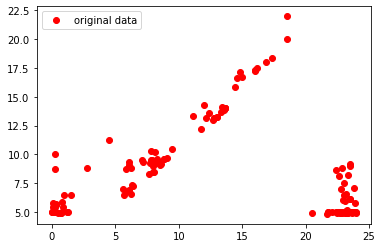

In [5]:
plt.plot(sleep_data['Slept'], sleep_data['Got up'], 'ro', label='original data')
plt.legend()
plt.show()

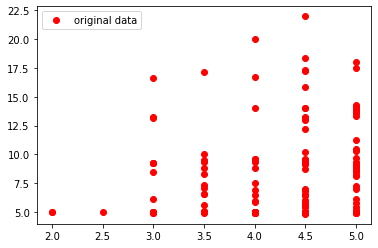

In [6]:
plt.plot(sleep_data['Rating'], sleep_data['Got up'], 'ro', label='original data')
plt.legend()
plt.show()

In [7]:
sleeping_time = []
for i, j in enumerate(sleep_data['Slept']):
  t = sleep_data['Got up'][i] - j
  if t < 0:
    t += 24
  sleeping_time.append(t)
print(sleeping_time[:3])

[5.5, 0.4166666666666661, 6.0]


In [8]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.5.0


In [9]:
train_dataset = sleep_data.sample(frac=0.8,random_state=0)
test_dataset = sleep_data.drop(train_dataset.index)

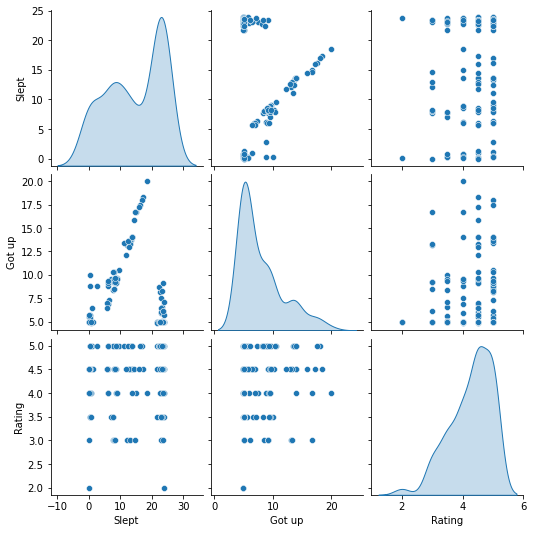

In [10]:
sns.pairplot(train_dataset[["Slept", "Got up", "Rating"]], diag_kind="kde")

In [11]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Slept,133.0,14.551754,8.806580,0.000000,7.833333,14.583333,23.083333,23.983333
Got up,133.0,7.856892,3.755222,4.833333,4.983333,5.916667,9.333333,20.000000
Rating,133.0,4.266917,0.689611,2.000000,4.000000,4.500000,5.000000,5.000000


In [12]:
train_labels = train_dataset.pop('Got up')
test_labels = test_dataset.pop('Got up')

In [13]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [14]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [15]:
model = build_model()

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


In [17]:
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

array([[1.1078801 ],
       [1.2014384 ],
       [0.5539207 ],
       [0.64030427],
       [1.5528389 ],
       [2.06093   ],
       [3.2581713 ],
       [3.3000264 ],
       [2.579019  ],
       [0.621752  ]], dtype=float32)

In [20]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [21]:
EPOCHS = 1000

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [22]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.466743,0.893277,2.466743,2.148005,0.921082,2.148005,995
996,2.244818,0.813094,2.244818,2.132920,0.846220,2.132920,996
997,2.388239,0.887761,2.388239,2.295035,0.870650,2.295035,997
998,2.306005,0.852777,2.306005,2.292569,1.080623,2.292569,998
999,2.333480,0.893289,2.333480,2.228486,0.976637,2.228486,999


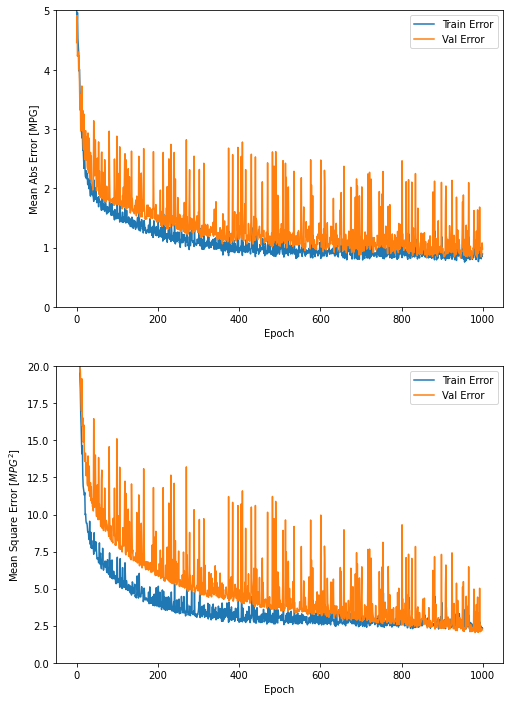

In [23]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)


....................................................................................................
....................................................................................................
..................

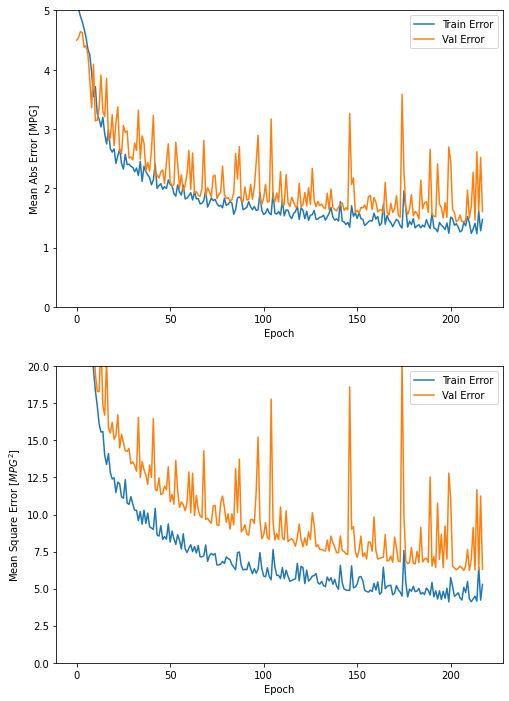

In [25]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_dataset, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [26]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

2/2 - 0s - loss: 8.9389 - mae: 1.8792 - mse: 8.9389
테스트 세트의 평균 절대 오차:  1.88 MPG


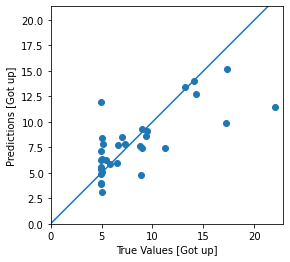

In [28]:
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Got up]')
plt.ylabel('Predictions [Got up]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

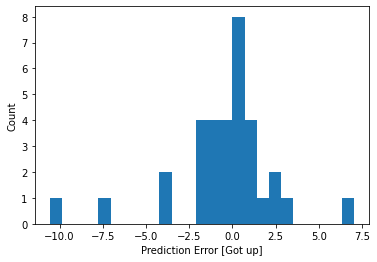

In [29]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Got up]")
_ = plt.ylabel("Count")